# Importación y preprocesamiento


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [3]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [4]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [5]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [6]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [7]:
import pylab as pl

In [87]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (DIV101_703)
Outside       34.680135
End           23.456790
DIV103_204    11.111111
DIV104_602     7.182941
DIV101_604     6.060606
DIV101_603     5.162738
DIV103_107     5.050505
DIV102_203     4.040404
OPR102_003     3.030303
OPR101_033     0.112233
OPR102_001     0.112233
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

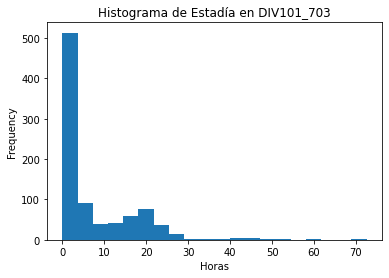

In [159]:
area = "DIV101_703"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}",bins = 20)
hist.set_xlabel("Horas")

## Analizamos caso a a caso

In [7]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

In [8]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


# Estado actual de los KPI

### Lead time promedio

In [91]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [92]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas cada día')

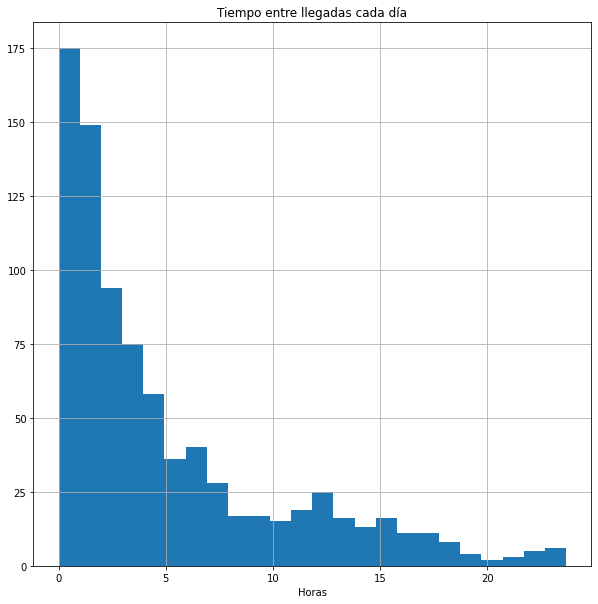

In [10]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24, figsize=(10,10))
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas cada día")

In [12]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
print('Tiempo entre llegadas de pacientes')
tiempo_filtrado.describe()

Tiempo entre llegadas de pacientes


count    843.000000
mean       5.058066
std        5.268105
min        0.000000
25%        1.200000
50%        3.050000
75%        7.016667
max       23.666667
Name: Entrada, dtype: float64

,sumsquare_error,aic,bic,kl_div
halfcauchy,0.027976,820.437217,-8680.704904,inf
foldcauchy,0.028391,824.091098,-8661.541248,inf
powerlognorm,0.029278,807.510133,-8628.871488,inf
recipinvgauss,0.030685,795.870395,-8596.045784,inf
pareto,0.030699,807.311675,-8595.657400,inf


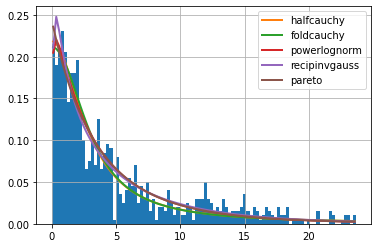

In [163]:
fit_llegadas_exp = Fitter(tiempo_filtrado)
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()

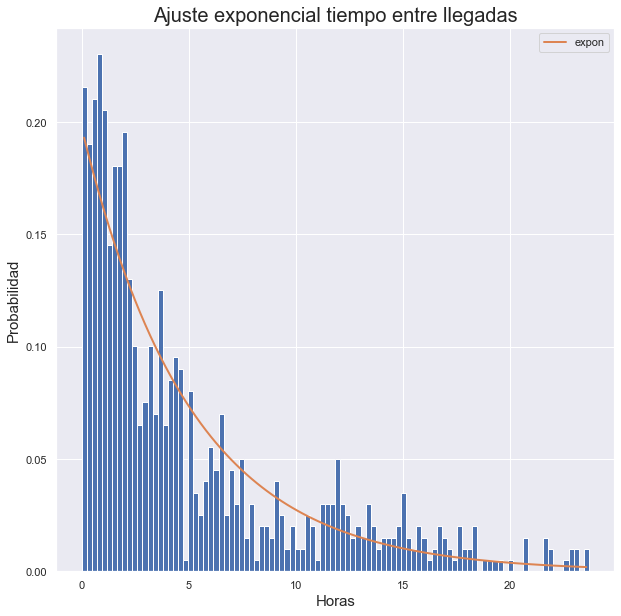

In [86]:
tiempo_filtrado = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]

plt.figure(figsize=(10, 10))
fit_llegadas_exp = Fitter(tiempo_filtrado, distributions=["expon"])
fit_llegadas_exp.fit()
fit_llegadas_exp.summary()
plt.title('Ajuste exponencial tiempo entre llegadas', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Probabilidad', fontsize=15)
plt.show()

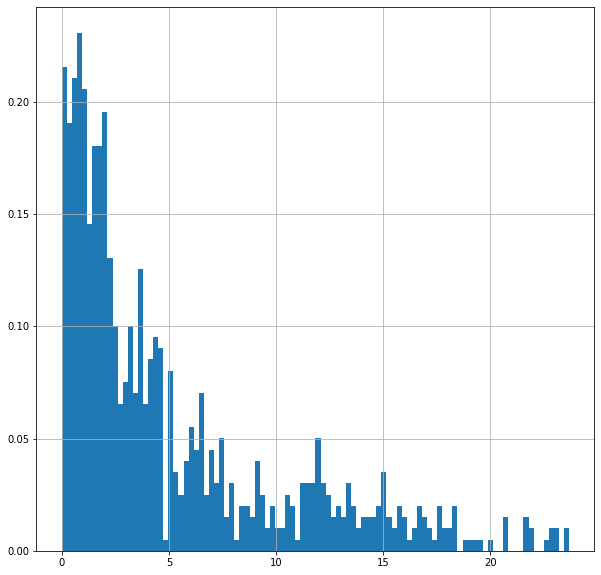

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.04000307721745858  and p value is: 0.8414745646251085
Failed to reject the null hypothesis -> La distribución ajusta los datos


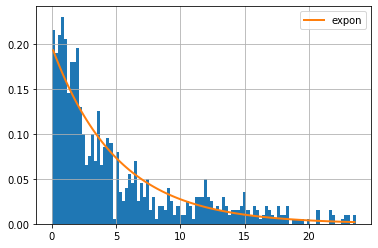

In [165]:
result_llegadas = fit_llegadas_exp.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_llegadas['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

In [26]:
dic_distribuciones = {}
dic_distribuciones['LLEGADAS'] = fit_llegadas_exp.get_best()
print('Parametros ajuste exponencial tiempo entre llegada de pacientes')
parametros = dic_distribuciones['LLEGADAS']['expon']
print(f'Location: {parametros[0]} \nScale: {parametros[1]}')

Parametros ajuste exponencial tiempo entre llegada de pacientes
Location: 0.0 
Scale: 5.058066429418743


Text(0.5, 0, 'Hora del día')

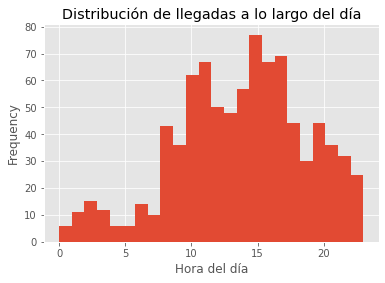

In [15]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Analisis de operaciones

In [16]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650494
4.1
0.0


Text(0.5, 0, 'Horas')

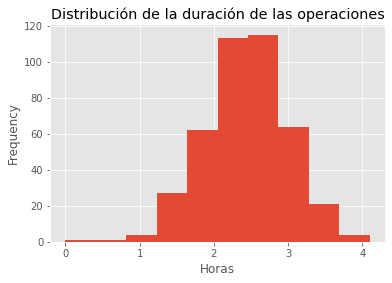

In [17]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

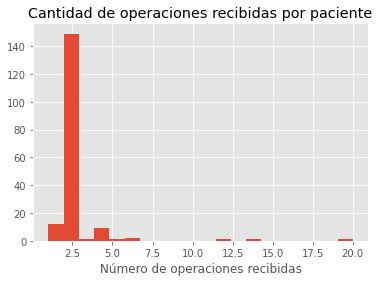

In [18]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

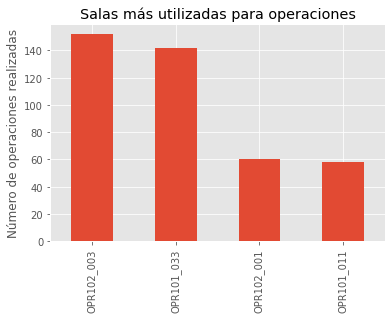

In [19]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [20]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4


In [21]:
areas_mapa_profe

['URG101_003',
 'DIV101_603',
 'DIV101_604',
 'DIV101_703',
 'DIV102_203',
 'DIV103_107',
 'DIV103_204',
 'DIV104_602',
 'OPR101_011',
 'OPR101_033',
 'OPR102_001',
 'OPR102_003',
 'End']

# Distribuciones por sala

In [10]:
from scipy import stats

In [23]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        f = Fitter(estadia,distributions = ["expon","beta","lognorm","norm",])
        f.fit()
        best = f.get_best(method = "sumsquare_error")
        dic_distribuciones[area] = best
        print(area,"lista")
    
    except:
        continue
        


URG101_003 lista
DIV101_603 lista
DIV101_604 lista
DIV101_703 lista
DIV102_203 lista
DIV103_107 lista
DIV103_204 lista
DIV104_602 lista
OPR101_011 lista
OPR101_033 lista
OPR102_001 lista


OPR102_003 lista


## Test de bondad 
Recordar que **si el p-value es menor a 0.05 implica que la distribución ajusta de buena manera a los datos**. Si el p-values es mayor a 0.05 significa que no hay información suficiente para justificar que la distribución ajusta de buena manera.

In [24]:
import math
for area in areas_mapa_profe:
    if area != 'End':
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        distribucion = list(dic_distribuciones[area].keys())[0]

        if distribucion == 'beta':
            param_a = dic_distribuciones[area]['beta'][0]
            param_b = dic_distribuciones[area]['beta'][1]
            loc = dic_distribuciones[area]['beta'][2]
            scale = dic_distribuciones[area]['beta'][3]
            esperado = (np.random.beta(a=param_a, b=param_b, size=len(estadia)) - loc) / scale

        elif distribucion == 'lognorm':
            s = dic_distribuciones[area]['lognorm'][0]
            loc = dic_distribuciones[area]['lognorm'][1]
            scale = dic_distribuciones[area]['lognorm'][2]
                
            esperado = (np.random.lognormal(mean=math.log(scale), sigma=s, size=len(estadia)) - loc) / scale

        else:
            print('Distribucion desconocida')

        test_bondad = stats.chisquare(f_obs = estadia, f_exp = esperado)
        print(area)
        resultado_test = list(test_bondad)
        print(f'Estadístico:{resultado_test[0]} p-value: {resultado_test[1]} \n')

URG101_003
Estadístico:12638078.850782946 p-value: 0.0 

DIV101_603
Estadístico:619327148948223.9 p-value: 0.0 

DIV101_604
Estadístico:1936609018192349.0 p-value: 0.0 

DIV101_703
Estadístico:1867711104957.9626 p-value: 0.0 

DIV102_203
Estadístico:4.560246072839681e+17 p-value: 0.0 

DIV103_107
Estadístico:231555664610548.38 p-value: 0.0 

DIV103_204
Estadístico:577668802390145.8 p-value: 0.0 

DIV104_602
Estadístico:1.4381354933849255e+20 p-value: 0.0 

OPR101_011
Estadístico:7241.892795703271 p-value: 0.0 

OPR101_033
Estadístico:-30534.52758811228 p-value: 1.0 

OPR102_001
Estadístico:-8383.142685368659 p-value: 1.0 

OPR102_003
Estadístico:275.9708010748603 p-value: 2.3152360752580137e-09 



In [25]:
dic_distribuciones

{'URG101_003': {'beta': (0.9963865319265526,
   7.549140779895584,
   -5.8548793004373246e-30,
   22.24393218386804)},
 'DIV101_603': {'beta': (0.3616704354973971,
   165.16296501053603,
   -7.412371308927781e-26,
   6922.807468149733)},
 'DIV101_604': {'beta': (0.45703588480386004,
   648.4486740488123,
   -8.513612931753873e-29,
   35054.048864844575)},
 'DIV101_703': {'beta': (0.5703786223184792,
   110.83109431271232,
   -1.462673655225481e-28,
   437.32033985936954)},
 'DIV102_203': {'beta': (0.24377071043553353,
   285.52176298361917,
   -1.187635564202615e-26,
   5018.705281761797)},
 'DIV103_107': {'beta': (0.39836402842306595,
   206.40113822847783,
   -1.5712666431312037e-28,
   10158.914732260619)},
 'DIV103_204': {'beta': (0.4888117957179907,
   109.8607935613231,
   -1.5936649681747108e-28,
   5313.91647884571)},
 'DIV104_602': {'beta': (0.15192779271070977,
   194.10258963560304,
   -5.156397043984947e-29,
   8814.947865303959)},
 'OPR101_011': {'beta': (0.580887388605725

In [26]:
dic_histogramas= {}

{'lognorm': (1.1325392177517544, -0.1631080499945431, 3.01277091110916)}


,sumsquare_error,aic,bic,kl_div
lognorm,0.033620,814.881030,-8519.048424,inf
chi2,0.037207,794.198271,-8433.592650,inf
beta,0.062616,758.059596,-7988.039146,inf
norm,0.228845,853.969495,-6908.970436,inf


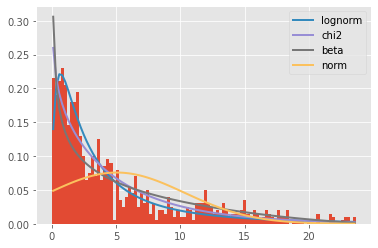

In [27]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
duracion_operaciones = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
duracion_operaciones = np.array(duracion_operaciones)
f = Fitter(duracion_operaciones,distributions = ["norm","beta","lognorm","chi2"])
f.fit()
a = f.get_best(method = "sumsquare_error")
print(a)
f.summary()


In [28]:
dic_histogramas["Tiempo_entre_llegadas"] = a

# Transiciones entre salas
Aqui se realiza un mapa de calor

In [27]:
df_heatmap = pd.DataFrame(index = areas_mapa_profe,columns = areas_mapa_profe)

In [28]:
areas_mapa_profe.append("Outside")

In [31]:
for area in areas_mapa_profe:
    derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
    transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])
    df_heatmap[area] = transiciones

In [32]:
df_heatmap.fillna(0)

,URG101_003,DIV101_603,DIV101_604,DIV101_703,DIV102_203,DIV103_107,DIV103_204,DIV104_602,OPR101_011,OPR101_033,OPR102_001,OPR102_003,End,Outside
URG101_003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005102,0.008264,0.017241,0.021127,0.000000,0.006579,0.998847,0.000000
DIV101_603,0.000000,0.000000,0.000000,0.051627,0.014085,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026549
DIV101_604,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024336
DIV101_703,0.990847,0.000000,0.000000,0.000000,0.000000,0.000000,0.010204,0.008264,0.017241,0.126761,0.000000,0.013158,0.000000,0.002212
DIV102_203,0.001144,0.016667,0.000000,0.040404,0.000000,0.000000,0.000000,0.000000,0.482759,0.000000,0.016667,0.000000,0.000000,0.008850
DIV103_107,0.000000,0.016667,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.051724,0.000000,0.016667,0.000000,0.000000,0.004425
DIV103_204,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.485915,0.000000,0.098684,0.000000,0.028761
DIV104_602,0.001144,0.000000,0.000000,0.071829,0.000000,0.000000,0.127551,0.000000,0.017241,0.077465,0.000000,0.019737,0.000000,0.035398
OPR101_011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008264,0.000000,0.000000,0.950000,0.000000,0.000000,0.000000
OPR101_033,0.000000,0.000000,0.000000,0.001122,0.000000,0.000000,0.045918,0.000000,0.000000,0.000000,0.000000,0.828947,0.000000,0.013274


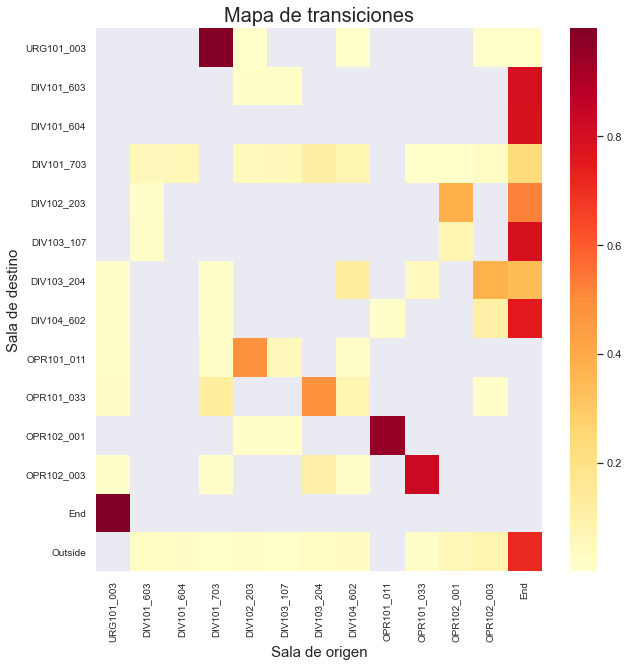

In [45]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
mapa = sns.heatmap(df_heatmap.T,annot = False, cmap = "YlOrRd")
mapa.axes.set_title("Mapa de transiciones",fontsize=20)
mapa.set_xlabel("Sala de origen",fontsize=15)
mapa.set_ylabel("Sala de destino",fontsize=15)
mapa.tick_params(labelsize=10)
#sns.show()

# Pacientes por día

In [34]:
salas_div  = areas_mapa_profe[:-5]

In [35]:
estadias_div = []
for paciente in set_pacientes :
    info_pacientes = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    info_hospitalizacion = info_pacientes[info_pacientes["Area"].isin(salas_div)]
    estadia = np.sum(info_pacientes["Estadia"])
    estadias_div.append(estadia)
estadia_serie = pd.Series(estadias_div)
estadia_serie = estadia_serie[(estadia_serie >0)]
print("Media de estadia en div (suma)",estadia_serie.mean())

Media de estadia en div (suma) 17.17735714285716


In [36]:
import datetime

In [37]:
def convertir_fecha(date):
    fecha = datetime.datetime.strftime(date,"%Y-%m-%d")
    return fecha

In [38]:
df_info_pacientes["Fecha_entrada"] = [convertir_fecha(df_info_pacientes["Entrada"].iloc[i]) for i in range(df_info_pacientes["Entrada"].shape[0])]

df_info_pacientes

,Entrada,Salida,Duracion,Ruta,Hora entrada,Fecha_entrada
14817280,2018-03-30 18:14:00,2018-03-30 22:06:00,3.866667,URG101_003DIV101_703DIV103_204End,18,2018-03-30
14931970,2018-05-13 16:37:00,2018-05-14 00:14:00,7.616667,URG101_003DIV101_703DIV102_203OPR102_001OPR101...,16,2018-05-13
14888963,2018-04-25 16:06:00,2018-04-26 12:26:00,20.333333,URG101_003DIV101_703OutsideEnd,16,2018-04-25
14696460,2018-02-15 12:04:00,2018-02-16 15:55:00,27.85,URG101_003DIV101_703DIV101_604End,12,2018-02-15
14579725,2018-01-04 21:05:00,2018-01-04 22:46:00,1.683333,URG101_003DIV101_703End,21,2018-01-04
...,...,...,...,...,...,...
14888950,2018-04-25 17:31:00,2018-05-15 14:18:00,476.783333,URG101_003DIV101_703OutsideDIV101_603End,17,2018-04-25
14682104,2018-02-08 14:27:00,2018-02-09 13:53:00,23.433333,URG101_003DIV101_703DIV104_602End,14,2018-02-08
14716923,2018-02-23 10:13:00,2018-02-23 18:39:00,8.433333,URG101_003DIV101_703End,10,2018-02-23
14716925,2018-02-23 17:47:00,2018-02-24 14:22:00,20.583333,URG101_003DIV101_703OutsideEnd,17,2018-02-23


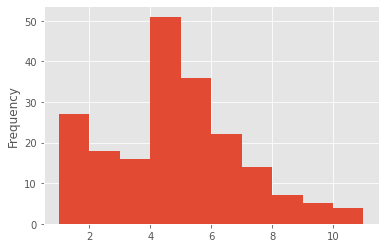

In [39]:
hist = df_info_pacientes["Fecha_entrada"].value_counts().plot.hist()


In [40]:
datos_atencion_urg = pd.read_csv("Datos_atencion_urg.csv")
ids_atencion = datos_atencion_urg["ID"]
set_atencion_urg = set(ids_atencion)
for paciente in set_pacientes:
    if paciente not in set_atencion_urg:
        print("Match")

Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Matc

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

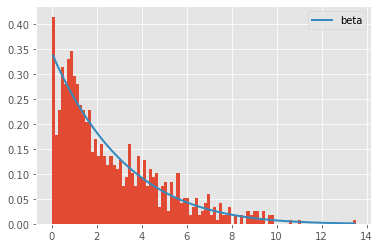

In [41]:
estadia = datos_pacientes[datos_pacientes["Area"] == "URG101_003"]["Estadia"]
estadia = np.array(estadia)
f = Fitter(estadia,distributions = ["beta"])
f.fit()
hist = f.summary()
plt.set_title("Estadia en URG101_003 distribución ajustada")
plt.set_xlabel("Horas")

In [ ]:
help(Fitter.summary)

# Ajuste de distribuciones de estadias OPR, DIV y URG

### Distribución OPRs

In [63]:
datos_operaciones['SALA OPERACIONES'].value_counts()

OPR102_003    152
OPR101_033    142
OPR102_001     60
OPR101_011     58
Name: SALA OPERACIONES, dtype: int64

Cantidad de datos de estadias en salas OPR 412
Tiempo medio de estadia en salas OPR: 2.4310679611650494


{'whiskers': [<matplotlib.lines.Line2D at 0x7fccff0ba280>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccff0ba820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccff0acf70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccff0badc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccff0aa0d0>],
 'means': []}

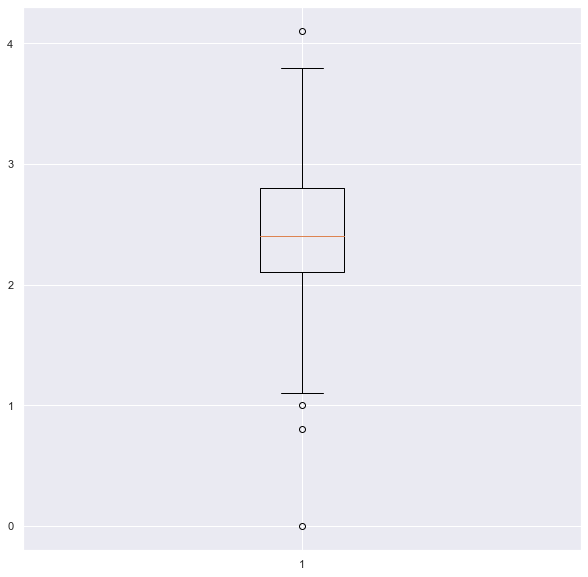

In [46]:
estadias_opr = datos_operaciones['DURACION (hrs)']
print(f'Cantidad de datos de estadias en salas OPR {len(datos_operaciones)}')
print(f'Tiempo medio de estadia en salas OPR: {np.mean(estadias_opr)}')
plt.boxplot(estadias_opr)

,sumsquare_error,aic,bic,kl_div
gennorm,19.606350,559.010495,-1236.546913,inf
johnsonsu,19.611286,533.397316,-1230.422174,inf
exponweib,19.614444,548.306045,-1230.355838,inf
skewnorm,19.615331,551.793813,-1236.358225,inf
powernorm,19.616234,548.759231,-1236.339274,inf


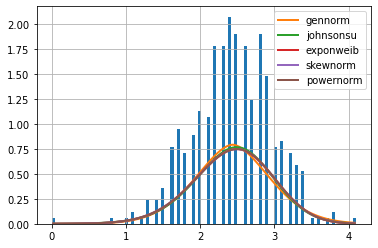

In [65]:
fit_opr = Fitter(estadias_opr)
fit_opr.fit()
fit_opr.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 19.606349881457756  and p value is: 9.51524333525633e-06
Null Hypothesis is rejected -> La distribución no ajusta los datos


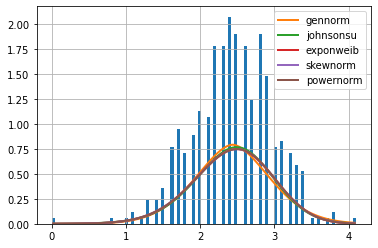

In [66]:
result_opr = fit_opr.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Rango: [1.0500000000000005 - 3.8499999999999996]
0.9902912621359223


{'whiskers': [<matplotlib.lines.Line2D at 0x7fccff0c4520>,
 'caps': [<matplotlib.lines.Line2D at 0x7fccff0c4ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fccff0c4250>],
 'medians': [<matplotlib.lines.Line2D at 0x7fccfce0a0a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fccfce0a370>],
 'means': []}

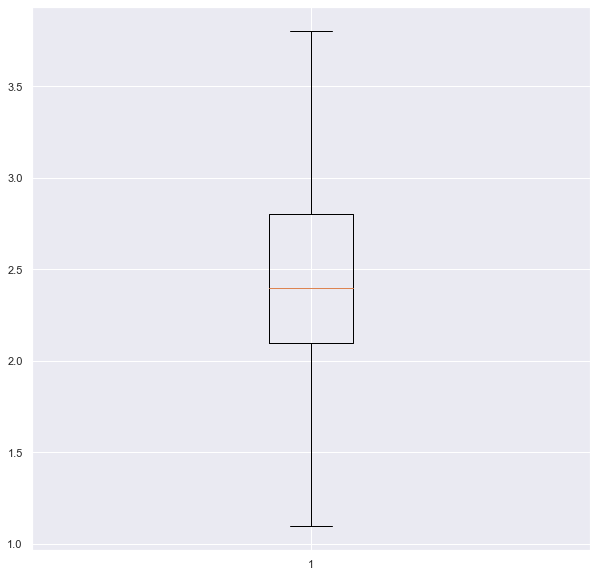

In [49]:
#plt.boxplot(estadias_urg)
s = np.std(estadias_opr, ddof=1)
mu = np.mean(estadias_opr)
iqr = stats.iqr(estadias_opr)
cota_superior = stats.scoreatpercentile(estadias_opr, 75) + 1.5*iqr
cota_inferior = max(stats.scoreatpercentile(estadias_opr, 25) - 1.5*iqr, 0)
#cota_inferior = 0

estadias_opr_filtrada = [x for x in estadias_opr if cota_inferior < x <= cota_superior]

#iqr = stats.iqr(estadias_div_filtrada)
#cota_superior = stats.scoreatpercentile(estadias_div_filtrada, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div_filtrada, 75) - 3*iqr, 0)

#estadias_div_filtrada = [x for x in estadias_div_filtrada if cota_inferior < x <= cota_superior]
print(f'Rango: [{cota_inferior} - {cota_superior}]')
print(len(estadias_opr_filtrada)/ len(estadias_opr))
plt.boxplot(estadias_opr_filtrada)

(array([ 7., 23., 43., 37., 95., 83., 57., 39., 20.,  4.]),
 array([1.1 , 1.37, 1.64, 1.91, 2.18, 2.45, 2.72, 2.99, 3.26, 3.53, 3.8 ]),
 <BarContainer object of 10 artists>)

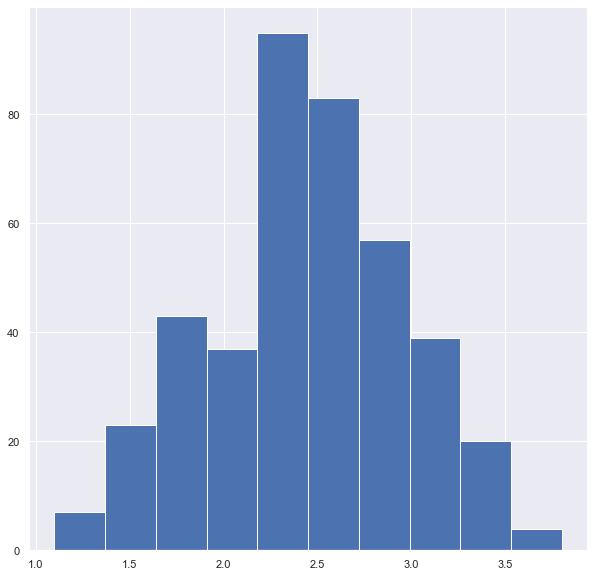

In [50]:
plt.hist(estadias_opr_filtrada)

,sumsquare_error,aic,bic,kl_div
powerlognorm,56.450621,289.498844,-782.938493,inf
pearson3,56.455935,287.907678,-788.911356,inf
loggamma,56.457706,287.814471,-788.898552,inf
johnsonsu,56.458117,289.833128,-782.884316,inf
powernorm,56.459095,287.709249,-788.888517,inf


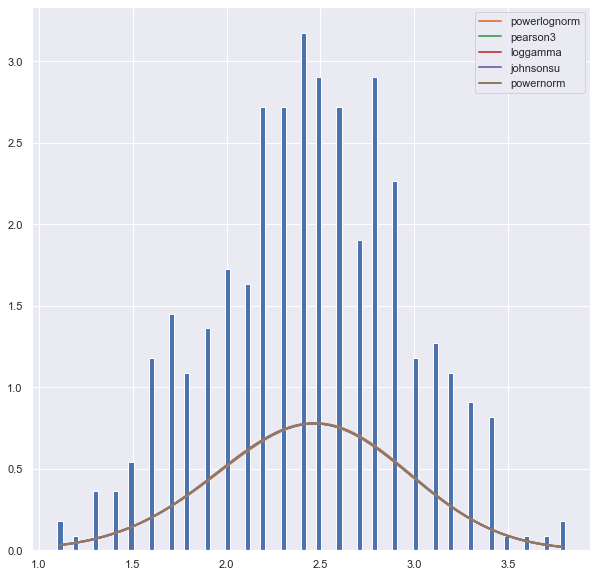

In [51]:
fit_opr = Fitter(estadias_opr_filtrada)
fit_opr.fit()
fit_opr.summary()

Test de hipotesis | Estadias salas OPR
chisquare-score: 56.450620826164545 
p value is: 5.762057497804562e-14
Hipótesis nula rechazada -> La distribución no ajusta los datos


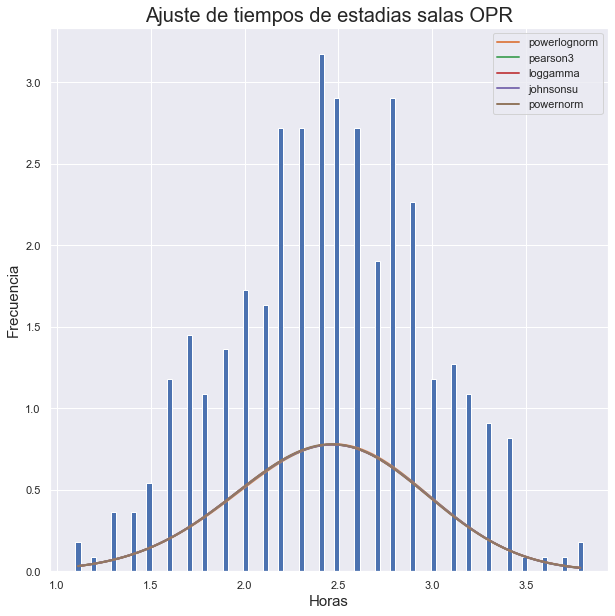

In [63]:
result_opr = fit_opr.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("Test de hipotesis | Estadias salas OPR")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Hipótesis nula rechazada -> La distribución no ajusta los datos"
        
print("chisquare-score:", chi_square, "\np value is:", p_value)
print(conclusion)

plt.title('Ajuste de tiempos de estadias salas OPR', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

In [86]:
datos_operaciones.groupby(['SALA OPERACIONES'])['DURACION (hrs)'].mean()

SALA OPERACIONES
OPR101_011    2.329310
OPR101_033    2.462676
OPR102_001    2.390000
OPR102_003    2.456579
Name: DURACION (hrs), dtype: float64

In [53]:
estadias_OPR101_011 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR101_011']['DURACION (hrs)']
estadias_OPR101_033 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR101_033']['DURACION (hrs)']
estadias_OPR102_001 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR102_001']['DURACION (hrs)']
estadias_OPR102_003 = datos_operaciones[datos_operaciones['SALA OPERACIONES']=='OPR102_003']['DURACION (hrs)']

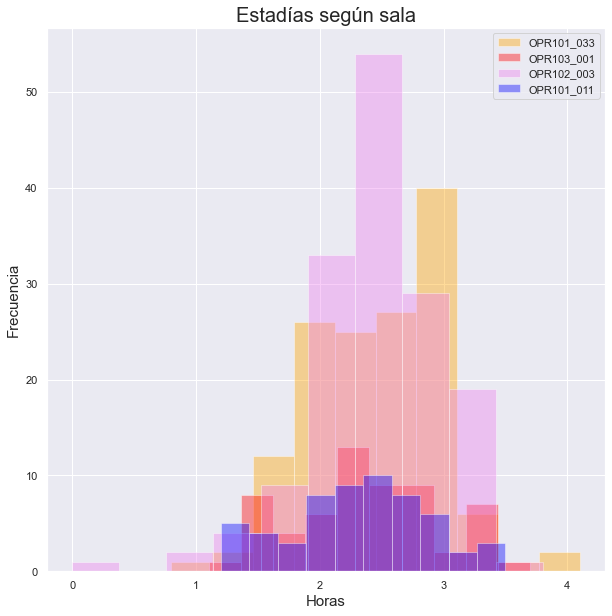

In [57]:
plt.hist(estadias_OPR101_033, alpha=0.4, label='OPR101_033', color="orange")
plt.hist(estadias_OPR102_001, alpha=0.4, label='OPR103_001', color="red")
plt.hist(estadias_OPR102_003, alpha=0.4, label='OPR102_003', color='violet')
plt.hist(estadias_OPR101_011, alpha=0.4, label='OPR101_011', color="blue")
plt.legend(loc='upper right')
plt.title('Estadías según sala', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

,sumsquare_error,aic,bic,kl_div
vonmises_line,96.178135,187.558806,41.515353,inf
triang,96.320871,200.903555,41.601366,inf
dgamma,96.412281,229.994644,41.656383,inf
gompertz,96.440067,194.602296,41.673096,inf
foldnorm,96.501352,200.503637,41.709941,inf


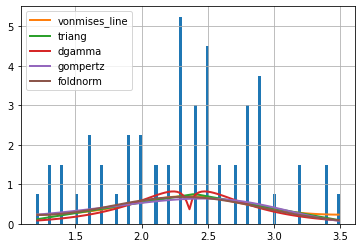

In [112]:
fit_opr_OPR101_011 = Fitter(estadias_OPR101_011)
fit_opr_OPR101_011.fit()
fit_opr_OPR101_011.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 96.17813519042643  and p value is: 0.0
Null Hypothesis is rejected -> La distribución no ajusta los datos


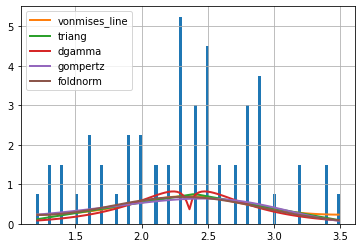

In [113]:
result_opr = fit_opr_OPR101_011.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

/Users/martin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error,aic,bic,kl_div
burr,40.125683,389.792079,-159.637776,inf
mielke,40.125687,389.792482,-159.637763,inf
weibull_min,40.339862,391.649228,-163.837665,inf
beta,40.367332,393.548979,-158.785173,inf
burr12,40.405268,389.857726,-158.651790,inf


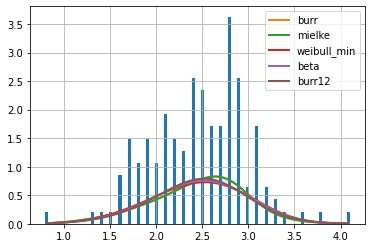

In [114]:
fit_opr_OPR101_033 = Fitter(estadias_OPR101_033)
fit_opr_OPR101_033.fit()
fit_opr_OPR101_033.summary()

The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 40.12568295800112  and p value is: 2.381373986892754e-10
Null Hypothesis is rejected -> La distribución no ajusta los datos


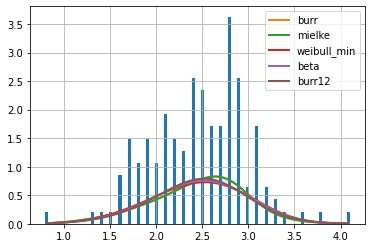

In [115]:
result_opr = fit_opr_OPR101_033.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_opr['sumsquare_error'][0]

print("The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected -> La distribución no ajusta los datos"
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Una forma de modelar esta distribución de manera muy rustica, es ajustar una distribución triangular para las estadias en las salas de operacion

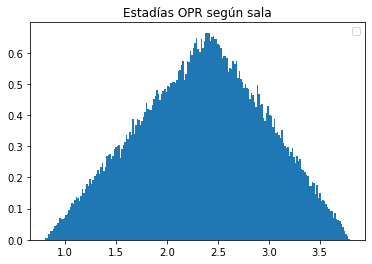

In [128]:
inf_range_opr = min(estadias_opr_filtrada)
sup_range_opr = max(estadias_opr_filtrada)
mean_opr = np.mean(estadias_opr_filtrada)

plt.hist(np.random.triangular(inf_range_opr, mean_opr, sup_range_opr, 100000), bins=200, density=True)
plt.legend(loc='upper right')
plt.title('Estadías OPR según sala')
plt.show()

In [65]:
posibles_estadias_opr = list(datos_operaciones['DURACION (hrs)'].value_counts().index)
freq_posibles_estadias_opr = datos_operaciones['DURACION (hrs)'].value_counts().reset_index(drop=True)

data = {
    'estadia': posibles_estadias_opr,
    'freq': freq_posibles_estadias_opr
}

distr_estadias_opr = pd.DataFrame(data)
distr_estadias_opr['prob'] = distr_estadias_opr['freq']/ distr_estadias_opr['freq'].sum()
print('Tabla estadias salas OPR')
distr_estadias_opr

Tabla estadias salas OPR


,estadia,freq,prob
0,2.4,35,0.084951
1,2.8,32,0.077670
2,2.5,32,0.077670
3,2.2,30,0.072816
4,2.3,30,0.072816
5,2.6,30,0.072816
6,2.9,25,0.060680
7,2.7,21,0.050971
8,2.0,19,0.046117
9,2.1,18,0.043689


In [157]:
#distr_estadias_opr.to_csv('Prob_estadias_OPR.csv')  

Se almacena las posibles estadias en las operaciones y su probabilidad asociada.

### Distribución DIVs

In [67]:
DIVs = ['DIV101_603', 'DIV101_604','DIV102_203','DIV103_107', 'DIV103_204', 'DIV104_602', 'DIV101_703']
DIV_101_703 = ['DIV101_703']
URGs = ['URG101_003']

In [68]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
estadias_div101_603 = np.array([])
estadias_div101_604 = np.array([])
estadias_div101_703 = np.array([])
estadias_div102_203 = np.array([])
estadias_div103_107 = np.array([])
estadias_div103_204 = np.array([])
estadias_div104_602 = np.array([])
estadias_div = np.array([])
estadias_urg = np.array([])

for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)

        if area == 'URG101_003':
            estadias_urg = np.append(estadias_urg, estadia)
        elif area == 'DIV101_603':
            estadias_div101_603 = np.append(estadias_div101_603, estadia)
        elif area == 'DIV101_604':
            estadias_div101_604 = np.append(estadias_div101_604, estadia)
        elif area == 'DIV101_703':
            estadias_div101_703 = np.append(estadias_div101_703, estadia)
        elif area == 'DIV102_203':
            estadias_div102_203 = np.append(estadias_div102_203, estadia)
        elif area == 'DIV103_107':
            estadias_div103_107 = np.append(estadias_div103_107, estadia)
        elif area == 'DIV103_204':
            estadias_div103_204 = np.append(estadias_div103_204, estadia)
        elif area == 'DIV104_602':
            estadias_div104_602 = np.append(estadias_div104_602, estadia) 
        if area in DIVs:
            estadias_div = np.append(estadias_div, estadia)
    
    except:
        print('Hubo un error')

estadias_div101_603 = estadias_div101_603[estadias_div101_603 != 0]
estadias_div101_604 = estadias_div101_604[estadias_div101_604 != 0]
estadias_div101_703 = estadias_div101_703[estadias_div101_703 != 0]
estadias_div102_203 = estadias_div102_203[estadias_div102_203 != 0]
estadias_div103_107 = estadias_div103_107[estadias_div103_107 != 0]
estadias_div103_204 = estadias_div103_204[estadias_div103_204 != 0]
estadias_div104_602 = estadias_div104_602[estadias_div104_602 != 0]

In [70]:
print('Tiempo medio de estadias en salas DIV')
print(f'DIV101_603: {np.mean(estadias_div101_603)} hrs')
print(f'DIV101_604: {np.mean(estadias_div101_604)} hrs')
print(f'DIV101_703: {np.mean(estadias_div101_703)} hrs')
print(f'DIV102_203: {np.mean(estadias_div102_203)} hrs')
print(f'DIV103_107: {np.mean(estadias_div103_107)} hrs')
print(f'DIV103_204: {np.mean(estadias_div103_204)} hrs')
print(f'DIV104_602: {np.mean(estadias_div104_602)} hrs')


Tiempo medio de estadias en salas DIV
DIV101_603: 280.7527777777778 hrs
DIV101_604: 284.8571428571428 hrs
DIV101_703: 9.371212121212121 hrs
DIV102_203: 43.997058823529414 hrs
DIV103_107: 251.17727272727276 hrs
DIV103_204: 67.76614987080103 hrs
DIV104_602: 199.54888888888888 hrs


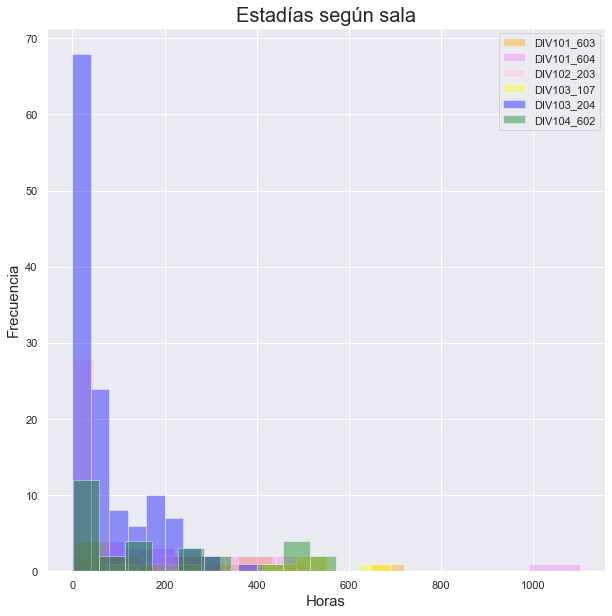

In [73]:
plt.hist(estadias_div101_603, alpha=0.4, label='DIV101_603', color="orange");
plt.hist(estadias_div101_604, alpha=0.4, label='DIV101_604', color="violet");
#plt.hist(estadias_div101_703, alpha=0.4, label='DIV101_703', color="red");
plt.hist(estadias_div102_203, alpha=0.4, label='DIV102_203', color="pink");
plt.hist(estadias_div103_107, alpha=0.4, label='DIV103_107', color="yellow");
plt.hist(estadias_div103_204, alpha=0.4, label='DIV103_204', color="blue");
plt.hist(estadias_div104_602, alpha=0.4, label='DIV104_602', color="green");
plt.legend(loc='upper right')
plt.title('Estadías según sala', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

Cantidad de datos de estadias: 1456


(array([1.377e+03, 4.000e+01, 1.500e+01, 7.000e+00, 1.300e+01, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.        ,  110.05666667,  220.11333333,  330.17      ,
         440.22666667,  550.28333333,  660.34      ,  770.39666667,
         880.45333333,  990.51      , 1100.56666667]),
 <BarContainer object of 10 artists>)

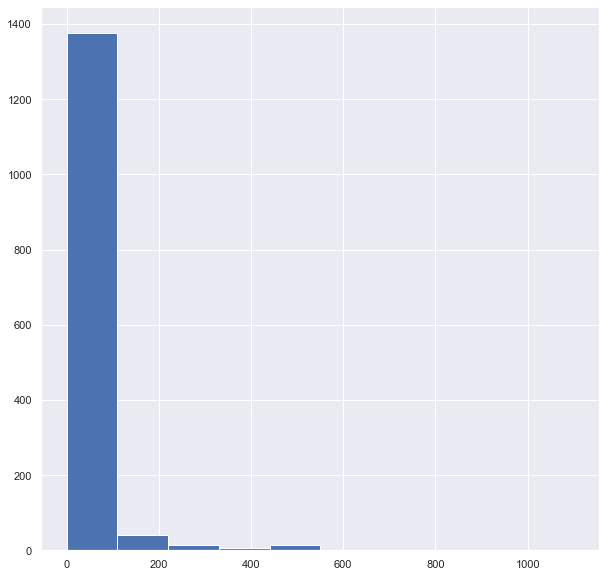

In [74]:
print(f'Cantidad de datos de estadias: {len(estadias_div)}')
plt.hist(estadias_div)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32f80f040>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa32f80f610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32f7fee80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa32f80fbb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa32f80fe80>],
 'means': []}

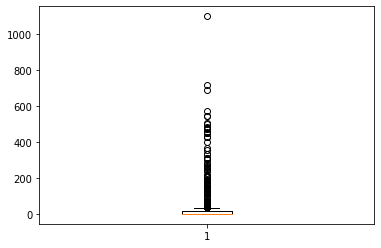

In [43]:
plt.boxplot(estadias_div)

0.5604395604395604


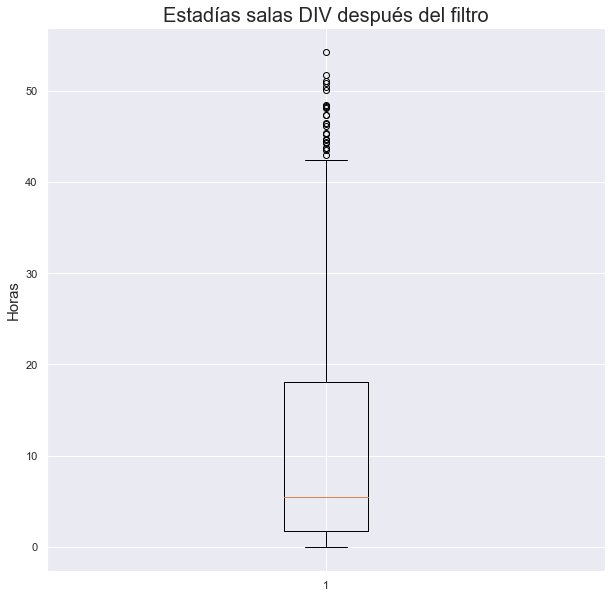

In [77]:
s = np.std(estadias_div, ddof=1)
mu = np.mean(estadias_div)
iqr = stats.iqr(estadias_div)
cota_superior = stats.scoreatpercentile(estadias_div, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div, 75) - 1.5*iqr, 0)
cota_inferior = 0

estadias_div_filtrada = [x for x in estadias_div if cota_inferior < x <= cota_superior]

#iqr = stats.iqr(estadias_div_filtrada)
#cota_superior = stats.scoreatpercentile(estadias_div_filtrada, 75) + 3*iqr
#cota_inferior = max(stats.scoreatpercentile(estadias_div_filtrada, 75) - 3*iqr, 0)

#estadias_div_filtrada = [x for x in estadias_div_filtrada if cota_inferior < x <= cota_superior]

print(len(estadias_div_filtrada)/ len(estadias_div))
plt.boxplot(estadias_div_filtrada)
plt.title('Estadías salas DIV después del filtro', fontsize=20)
plt.ylabel('Horas', fontsize=15)
plt.show()

Como se puede ver, luego de aplicar un filtro sobre los strong outliers, nos quedamos con el 56% de los datos de estadias en los div ya que gran parte de ellos eran valores 0s que no tenien sentido dentro del contexto de nuestro problema.

/Users/martin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


,sumsquare_error,aic,bic,kl_div
johnsonsb,0.016833,920.613937,-1273.910841,inf
bradford,0.017230,918.582133,-1275.538984,inf
recipinvgauss,0.017648,974.579106,-1272.109432,inf
levy,0.018270,1048.699686,-1272.117744,inf
halfgennorm,0.018410,990.533628,-1266.063296,inf


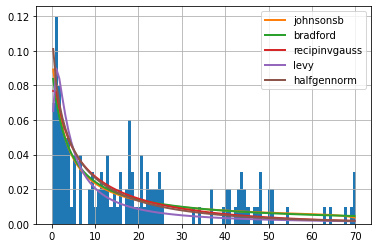

In [44]:
fit_divs = Fitter(estadias_div_filtrada)
fit_divs.fit()
fit_divs.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.016832501953262788  and p value is: 0.8967720298350979
Failed to reject the null hypothesis.


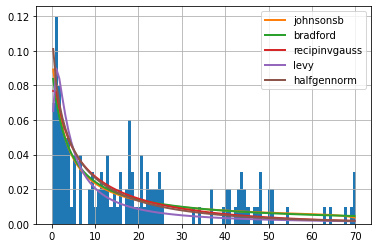

In [45]:
result_div = fit_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

,sumsquare_error,aic,bic,kl_div
gamma,0.018612,967.707132,-1264.499314,inf
exponpow,0.019042,948.984215,-1261.236980,inf
lognorm,0.021999,997.222656,-1240.592805,inf
expon,0.022224,956.713598,-1244.101250,inf
powerlaw,0.024566,884.985346,-1224.812092,inf


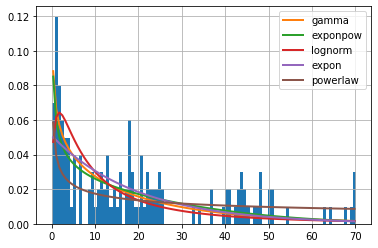

In [46]:
fit_common_divs = Fitter(estadias_div_filtrada, distributions = get_common_distributions())
fit_common_divs.fit()
fit_common_divs.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.018612469239901622  and p value is: 0.999997502688322
Failed to reject the null hypothesis.


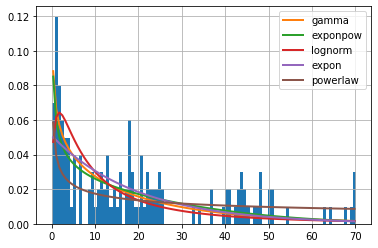

In [47]:
result_div = fit_common_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 5)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

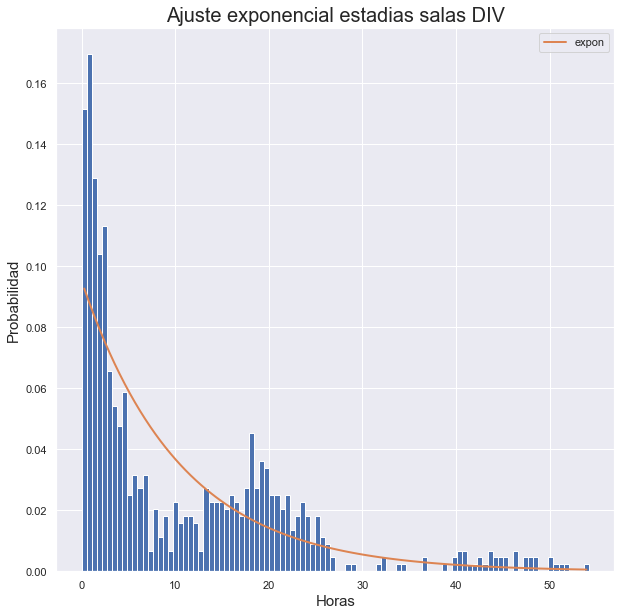

In [79]:
fit_expon_divs = Fitter(estadias_div_filtrada, distributions = ['expon'])
fit_expon_divs.fit()
fit_expon_divs.summary()
plt.title('Ajuste exponencial estadias salas DIV', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Probabilidad', fontsize=15)
plt.show()

Test de hipotesis | Estadias salas DIV
chisquare-score: 0.027123399935772778 
p value: 0.8691865453354974
No se puede rechazar la hipotesis nula -> La distribución ajusta los datos


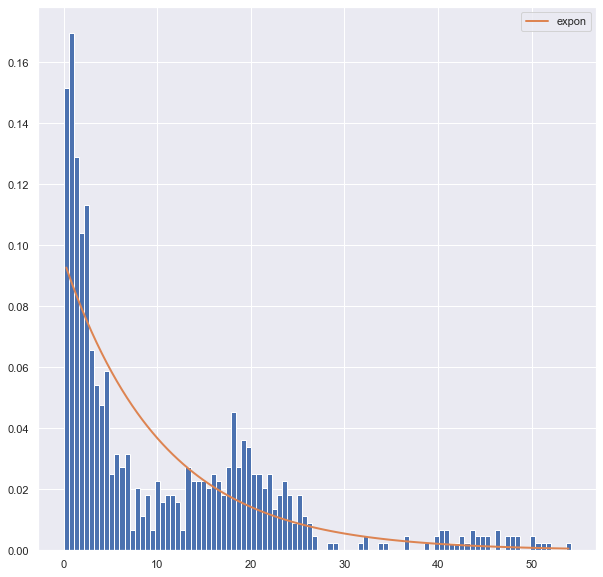

In [80]:
result_div = fit_expon_divs.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_div['sumsquare_error'][0]

print("Test de hipotesis | Estadias salas DIV")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "No se puede rechazar la hipotesis nula -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score:", chi_square, "\np value:", p_value)
print(conclusion)

In [81]:
dic_distribuciones['DIV'] = fit_expon_divs.get_best()
 # (location, scale)
print('Parametros ajuste exponencial estadias en salas DIV')
parametros = dic_distribuciones['DIV']['expon']
print(f'Location: {parametros[0]} \nScale: {parametros[1]}')

Parametros ajuste exponencial estadias en salas DIV
Location: 0.016666666666666666 
Scale: 10.515318627450977


### Distribución URGs

2.6080282227307396
874


(array([343., 196., 129.,  96.,  52.,  32.,  19.,   5.,   1.,   1.]),
 array([ 0.        ,  1.35333333,  2.70666667,  4.06      ,  5.41333333,
         6.76666667,  8.12      ,  9.47333333, 10.82666667, 12.18      ,
        13.53333333]),
 <BarContainer object of 10 artists>)

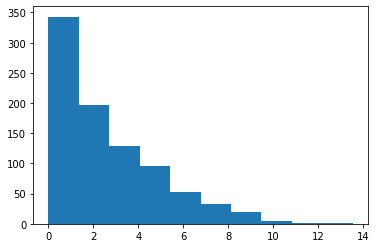

In [54]:
print(np.mean(estadias_urg))
print(len(estadias_urg))
plt.hist(estadias_urg)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa32f948520>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa32f948c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa32f948670>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa32fdd41f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa32fdd42e0>],
 'means': []}

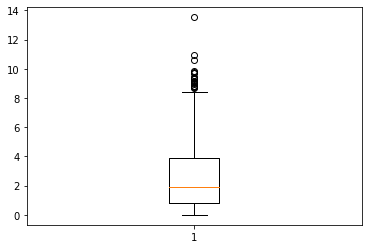

In [55]:
plt.boxplot(estadias_urg)

,sumsquare_error,aic,bic,kl_div
beta,0.079694,744.406346,-8103.416814,inf
exponweib,0.079804,722.330845,-8102.212743,inf
gengamma,0.080355,752.874324,-8096.198936,inf
gompertz,0.081410,756.292559,-8091.571462,inf
genexpon,0.081590,752.989280,-8076.090195,inf


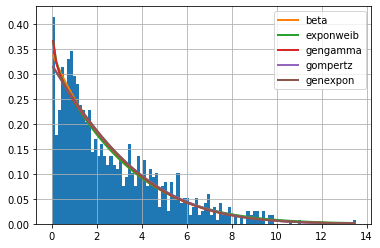

In [56]:
fit_urg = Fitter(estadias_urg)
fit_urg.fit()
fit_urg.summary()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.07969394603527917  and p value is: 0.7777125946930997
Failed to reject the null hypothesis.


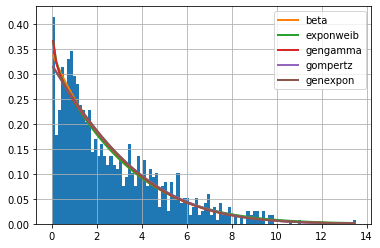

In [57]:
result_urg = fit_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

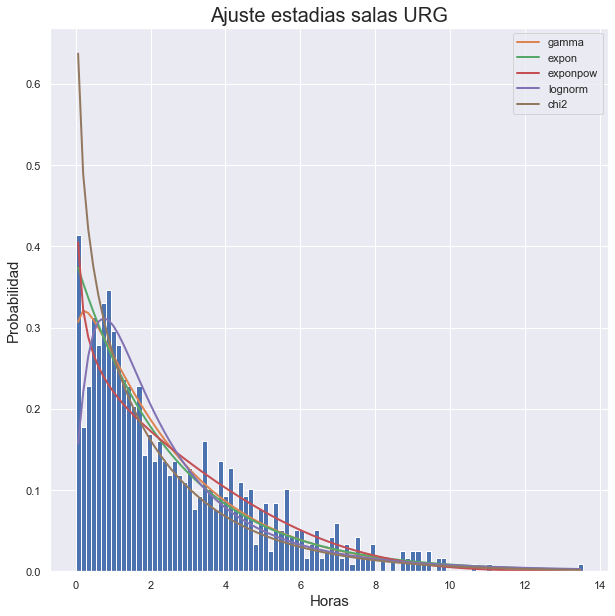

In [82]:
fit_common_urg = Fitter(estadias_urg, distributions= get_common_distributions())
fit_common_urg.fit()
fit_common_urg.summary()
plt.title('Ajuste estadias salas URG', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Probabilidad', fontsize=15)
plt.show()

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.08363982258175125  and p value is: 0.7724241214303732
Failed to reject the null hypothesis.


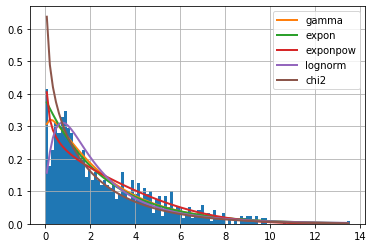

In [59]:
result_urg = fit_common_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

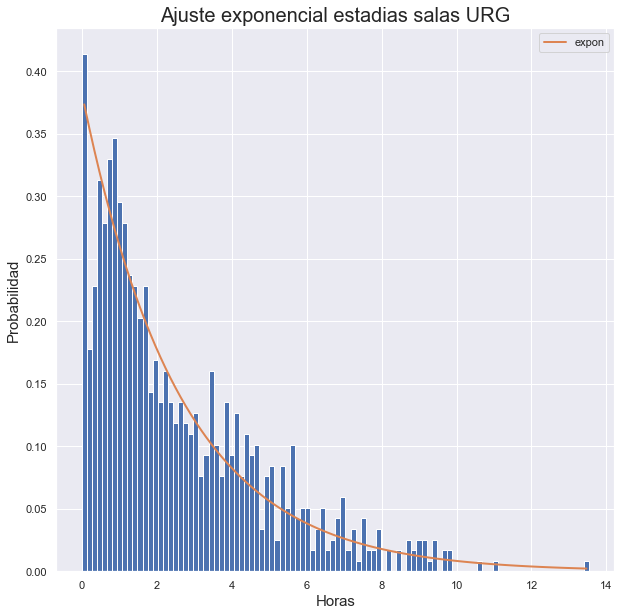

In [83]:
fit_expon_urg = Fitter(estadias_urg, distributions= ["expon"])
fit_expon_urg.fit()
fit_expon_urg.summary()
plt.title('Ajuste exponencial estadias salas URG', fontsize=20)
plt.xlabel('Horas', fontsize=15)
plt.ylabel('Probabilidad', fontsize=15)
plt.show()

Test de hipotesis | Estadias salas URG
chisquare-score is: 0.08770064641715104  and p value is: 0.7671209154163832
No se puede rechazar la hipotesis nula -> La distribución ajusta los datos


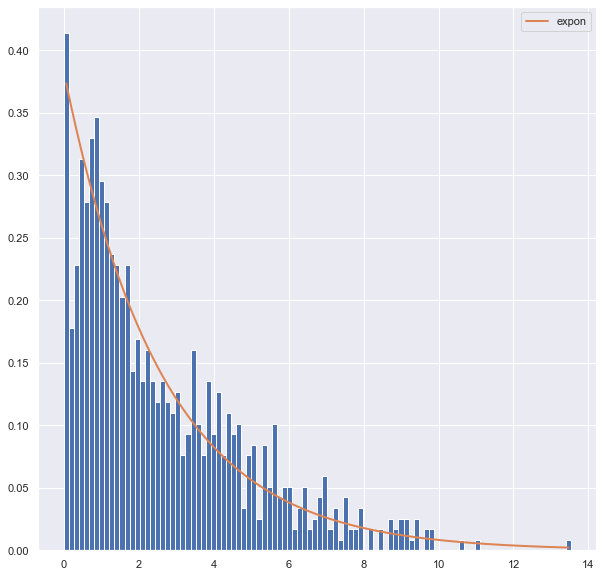

In [84]:
result_urg = fit_expon_urg.summary()

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = result_urg['sumsquare_error'][0]

print("Test de hipotesis | Estadias salas URG")
p_value = 1 - stats.chi2.cdf(chi_square, 1)
conclusion = "No se puede rechazar la hipotesis nula -> La distribución ajusta los datos"

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

In [85]:
dic_distribuciones['URG'] = fit_expon_urg.get_best()
  # (location, scale)
print('Parametros ajuste exponencial estadias en salas URG')
parametros = dic_distribuciones['URG']['expon']
print(f'Location: {parametros[0]} \nScale: {parametros[1]}')

Parametros ajuste exponencial estadias en salas URG
Location: 0.0 
Scale: 2.6080282227307396


# Ajuste a exponencial para la validación teorica de la simulación
Con estas tasas se realiza el modelo MMK con el que se ve la tasa de ocupación y podemos saber si la simluación debería diverger o no.

,sumsquare_error,aic,bic,kl_div
expon,0.00231,3132.805283,-6997.48966,inf


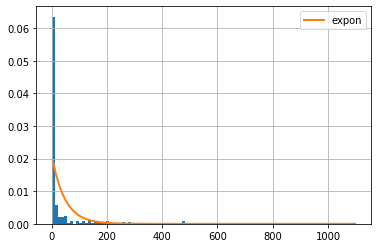

In [122]:
fit_estadias_div_exp = Fitter(estadias_div, distributions=["expon"])
fit_estadias_div_exp.fit()
fit_estadias_div_exp.summary()

In [84]:
fit_estadias_div_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 46.626873156342185}}

,sumsquare_error,aic,bic,kl_div
expon,0.04383,1799.537581,-18699.935716,inf


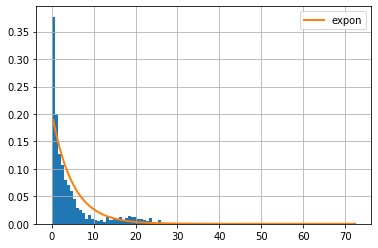

In [85]:
fit_estadias_urg_exp = Fitter(estadias_urg, distributions=["expon"])
fit_estadias_urg_exp.fit()
fit_estadias_urg_exp.summary()

In [86]:
fit_estadias_urg_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 4.912511803588291}}

,sumsquare_error,aic,bic,kl_div
expon,29.8361,350.31629,-1069.583318,inf


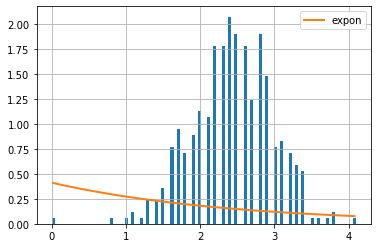

In [91]:
fit_estadias_opr_exp = Fitter(datos_operaciones['DURACION (hrs)'], distributions=["expon"])
fit_estadias_opr_exp.fit()
fit_estadias_opr_exp.summary()

In [92]:
fit_estadias_opr_exp.get_best(method = "sumsquare_error")

{'expon': {'loc': 0.0, 'scale': 2.4310679611650485}}

# Guardado distribuciones

In [173]:
keys = ['DIV', 'URG', 'LLEGADAS']
dict_archivo_distribuciones = {}
for k in dic_distribuciones.keys():
    if k in keys:
        dict_archivo_distribuciones[k] = dic_distribuciones[k]
df_archivo = pd.DataFrame(dict_archivo_distribuciones)
#df_archivo.to_csv('distribuciones_expon.csv')
df_archivo

,DIV,URG,LLEGADAS
expon,"(0.016666666666666666, 19.637412587412584)","(0.0, 2.6080282227307396)","(0.0, 5.058066429418743)"
